# 目的
遺伝子学的分類に基づいた、再発の2値分類を実施する。  

In [24]:
import os
import random
import itertools
import re

# 基本的なライブラリ
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

# 描画ライブラリ
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn_analyzer import CustomPairPlot
import graphviz
import pydotplus
from IPython.display import Image
from IPython.display import HTML
from six import StringIO
from ipywidgets import interact, FloatSlider

# データセット分割
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    ShuffleSplit,
    StratifiedShuffleSplit,
)

# 補完
from sklearn.experimental import (
    enable_iterative_imputer,
)  # IterativeImputerをimportするために必要
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

# エンコード
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder

# サンプリング
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# 特徴量選択
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import (
    GenericUnivariateSelect,
    f_classif,
    mutual_info_classif,
    chi2,
)
from boruta import BorutaPy
from libraries.mrmr import mrmr

# models
from lightgbm import LGBMClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier


# 学習中
import optuna
from tqdm import tqdm
from sklearn.model_selection import learning_curve, cross_validate, cross_val_score

# 評価指標
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings


# config python file
import config

SEED = config.SEED
# INDEX_MICROARRAY = config.INDEX_MICROARRAY
INDEX_MICROARRAY = 2
from functions import *

fix_seed(SEED)


# 最大表示列数の指定（ここでは50列を指定）N
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 50)

%matplotlib inline

In [25]:
df_recurrenced = pd.read_pickle(
    config.INTERIM_PREPROCESSED_RECURRENCE_CROSS_DIR + "/df_recurrenced.pkl"
)

# データ全体での予測モデル検証

## ベースモデルの学習結果

各特徴量選択されたdfを用いて基本的な2値分類モデルを学習する

In [26]:
def exists_data_files(file_path: str, file_name: str):
    data_phases = ["train", "val"]

    for data_phase in data_phases:
        X_path = "{0}/{1}/X_{2}.pkl".format(file_path, data_phase, file_name)
        y_path = "{0}/{1}/y_{2}.pkl".format(file_path, data_phase, file_name)
        if not (os.path.exists(X_path) and os.path.exists(y_path)):
            return False
    return True


def read_preprocessed_df(
    file_path: str = ".",
    file_name: str = "sample",
):

    if exists_data_files(file_path, file_name):
        X_train = pd.read_pickle("{0}/train/X_{1}.pkl".format(file_path, file_name))
        y_train = pd.read_pickle("{0}/train/y_{1}.pkl".format(file_path, file_name))
        X_val = pd.read_pickle("{0}/val/X_{1}.pkl".format(file_path, file_name))
        y_val = pd.read_pickle("{0}/val/y_{1}.pkl".format(file_path, file_name))
        """
        X_train_val = pd.read_pickle("{0}/train_val/X_{1}.pkl".format(file_path, file_name))
        y_train_val = pd.read_pickle("{0}/train_val/y_{1}.pkl".format(file_path, file_name))
        X_test = pd.read_pickle("{0}/test/X_{1}.pkl".format(file_path, file_name))
        y_test = pd.read_pickle("{0}/test/y_{1}.pkl".format(file_path, file_name))
        """
        list_train = [X_train, y_train]
        list_val = [X_val, y_val]
        """
        list_train_val = [X_train_val, y_train_val]
        list_test = [X_test, y_test]
        """
        return list_train, list_val  # , list_train_val, list_test

In [39]:
def validate_models(
    file_path: str = ".",
    file_name: str = "sample",
):
    try:
        list_train, list_val = read_preprocessed_df(file_path, file_name)
    except:
        return
    X_train, y_train = list_train[0], list_train[1].map(lambda x: int(x))
    X_val, y_val = list_val[0], list_val[1].map(lambda x: int(x))

    # accuracyの表示
    print("accuracy: ", (y_train == 1).sum() / y_train.shape[0])
    print("使用特徴量：", X_train.columns)
    print("学習サンプルサイズ：", X_train.shape)
    display(
        compare_bcms(
            X_train,
            y_train,
            X_val,
            y_val,
        )
    )


# サブグループ削除（一時的に）
subgroup_columns = [
    "CLAUDIN_SUBTYPE",
    "NPI_CAT",
    "TUMOR_CAT",
    "LYMPH_CAT",
]

methods = ["variance_threshold", "mrmr"]

for method in methods:  # 特徴選択手法の適用
    file_path = "./{0}/{1}/{2}".format(
        config.INTERIM_PREPROCESSED_RECURRENCE_CROSS_DIR,
        "ALL_DATA",
        method,
    )
    print("=====" * 10)
    print("method: ", method)
    validate_models(file_path=file_path, file_name="all_data")
    for subgroup_column in subgroup_columns:  # 各サブグループへの適用
        print("-----" * 10)
        print("subgroup column: ", subgroup_column)
        for subgroup in df_recurrenced[subgroup_column].unique():  # サブグループ毎への適用
            print("subgroup: ", subgroup)
            file_path = "./{0}/{1}/{2}".format(
                config.INTERIM_PREPROCESSED_RECURRENCE_CROSS_DIR,
                subgroup_column,
                method,
            )
            validate_models(file_path=file_path, file_name=subgroup)

method:  variance_threshold
accuracy:  0.38449111470113084
使用特徴量： Index(['SYT13', 'ANKRD30BP3', 'CA12', 'HLA-DRB4', 'LCN2', 'SERHL2', 'PVALB',
       'GABRP', 'IGJ', 'SNAR-A3', 'SERPINA3', 'KRT15', 'NAT1', 'GFRA1',
       'SFRP1', 'SLC7A2', 'MMP7', 'SERPINA5', 'SCGB3A1', 'KRT81', 'VTCN1',
       'CYP4Z1', 'GRIA2', 'STC2', 'KRT6B', 'LTF', 'CYP4X1', 'APOD', 'BMPR1B',
       'SCUBE2', 'IGLL1_1', 'TCN1', 'BEX1', 'IGHG1', 'UGT2B11', 'C1orf64',
       'PROM1', 'EEF1A2', 'CALML5', 'UGT2B7', 'HMGCS2', 'ESR1', 'CLIC6',
       'PPP1R1B', 'AGR3', 'SCGB2A1', 'HLA-A', 'VAV3', 'S100A8', 'S100P',
       'TFF3', 'S100A9', 'IGKC', 'CLEC3A', 'CPB1', 'HLA-DRB1', 'ANKRD30A',
       'TFF1', 'PIP', 'SCGB1D2', 'SCGB2A2'],
      dtype='object')
学習サンプルサイズ： (619, 61)


11it [00:02,  5.13it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Naive Bayes,0.621971,0.623188,0.613861,0.606061
Linear SVM,0.726979,0.652174,0.689908,0.600000
Random Forest,0.817447,0.637681,0.782274,0.590164
RBF SVM,0.786753,0.608696,0.759124,0.557377
Decision Tree,0.794830,0.608696,0.742394,0.526316
Quadratic Discriminant Analysis,0.972536,0.623188,0.963441,0.500000
AdaBoost,0.859451,0.637681,0.807095,0.489796
Polynomial SVM,0.998384,0.565217,0.997904,0.482759
Logistic Regression,0.731826,0.608696,0.631111,0.448980


--------------------------------------------------
subgroup column:  CLAUDIN_SUBTYPE
subgroup:  LumB
accuracy:  0.39325842696629215
使用特徴量： Index(['IGLL1_1', 'BMPR1B', 'CLIC6', 'GRIA2', 'VAV3', 'HLA-A', 'BEX1', 'S100P',
       'CLEC3A', 'IGKC', 'TFF1', 'ANKRD30A', 'HLA-DRB1', 'SCGB1D2', 'CPB1',
       'PIP', 'SCGB2A2'],
      dtype='object')
学習サンプルサイズ： (178, 17)


11it [00:00, 27.62it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Decision Tree,0.769663,0.55,0.748466,0.526316
Quadratic Discriminant Analysis,1.000000,0.60,1.000000,0.428571
Linear SVM,0.679775,0.45,0.645963,0.421053
AdaBoost,0.971910,0.45,0.964029,0.352941
Polynomial SVM,0.977528,0.40,0.972222,0.333333
Logistic Regression,0.707865,0.50,0.573770,0.285714
RBF SVM,0.803371,0.40,0.758621,0.250000
Random Forest,0.792135,0.40,0.748299,0.250000
Naive Bayes,0.679775,0.40,0.577778,0.142857


subgroup:  Her2
accuracy:  0.25555555555555554
使用特徴量： Index(['IGKC', 'PPP1R1B', 'S100A8', 'UGT2B11', 'UGT2B7', 'S100A9', 'PIP',
       'SCGB1D2', 'SCGB2A2'],
      dtype='object')
学習サンプルサイズ： (90, 9)


11it [00:00, 39.45it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Nearest Neighbors,0.833333,0.727273,0.594595,0.571429
Polynomial SVM,0.866667,0.636364,0.769231,0.500000
RBF SVM,0.822222,0.636364,0.680000,0.500000
Decision Tree,0.777778,0.636364,0.629630,0.333333
Linear SVM,0.677778,0.363636,0.553846,0.222222
AdaBoost,1.000000,0.545455,1.000000,0.000000
Logistic Regression,0.766667,0.727273,0.322581,0.000000
Naive Bayes,0.744444,0.636364,0.410256,0.000000
Quadratic Discriminant Analysis,1.000000,0.636364,1.000000,0.000000


subgroup:  LumA
accuracy:  0.5393258426966292
使用特徴量： Index(['IGKC', 'UGT2B11', 'TFF1', 'GRIA2', 'BEX1', 'UGT2B7', 'TCN1', 'S100P',
       'HMGCS2', 'PIP', 'VAV3', 'CLIC6', 'SCGB2A2', 'HLA-DRB1', 'CPB1',
       'CLEC3A', 'SCGB1D2'],
      dtype='object')
学習サンプルサイズ： (178, 17)


11it [00:00, 30.46it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Quadratic Discriminant Analysis,1.000000,0.70,1.000000,0.769231
Naive Bayes,0.662921,0.65,0.693878,0.740741
Nearest Neighbors,0.679775,0.65,0.713568,0.740741
RBF SVM,0.758427,0.60,0.777202,0.692308
Random Forest,0.780899,0.60,0.795812,0.692308
Linear SVM,0.691011,0.55,0.715026,0.640000
Logistic Regression,0.668539,0.55,0.703518,0.640000
AdaBoost,0.966292,0.55,0.969388,0.608696
Decision Tree,0.741573,0.50,0.726190,0.545455


subgroup:  claudin-low
subgroup:  Basal
subgroup:  Normal
subgroup:  NC
--------------------------------------------------
subgroup column:  NPI_CAT
subgroup:  3.4~5.4
accuracy:  0.3706896551724138
使用特徴量： Index(['IGLL1_1', 'APOD', 'SCUBE2', 'UGT2B7', 'GABRP', 'KRT81', 'HMGCS2',
       'MMP7', 'KRT6B', 'PROM1', 'C1orf64', 'TCN1', 'CLIC6', 'SCGB2A1',
       'EEF1A2', 'CALML5', 'S100P', 'ESR1', 'PPP1R1B', 'VAV3', 'HLA-A',
       'S100A8', 'AGR3', 'IGKC', 'S100A9', 'CPB1', 'CLEC3A', 'HLA-DRB1',
       'TFF3', 'ANKRD30A', 'TFF1', 'SCGB1D2', 'PIP', 'SCGB2A2'],
      dtype='object')
学習サンプルサイズ： (348, 34)


11it [00:01, 10.11it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Linear SVM,0.689655,0.666667,0.644737,0.606061
RBF SVM,0.758621,0.615385,0.730769,0.594595
Naive Bayes,0.609195,0.589744,0.600000,0.578947
Sigmoid SVM,0.370690,0.384615,0.540881,0.555556
Logistic Regression,0.698276,0.692308,0.545455,0.500000
Polynomial SVM,0.994253,0.615385,0.992248,0.482759
Decision Tree,0.758621,0.589744,0.718121,0.466667
Random Forest,0.787356,0.538462,0.750000,0.437500
AdaBoost,0.905172,0.564103,0.872587,0.370370


subgroup:  5.4~inf
accuracy:  0.24545454545454545
使用特徴量： Index(['S100A8', 'IGKC', 'HLA-A', 'S100A9', 'TFF3', 'SCGB1D2', 'ANKRD30A',
       'TFF1', 'HLA-DRB1', 'PIP', 'SCGB2A2'],
      dtype='object')
学習サンプルサイズ： (110, 11)


11it [00:00, 41.35it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Decision Tree,0.736364,1.000000,0.591549,1.000000
Naive Bayes,0.727273,0.846154,0.444444,0.666667
Linear SVM,0.654545,0.692308,0.500000,0.500000
Polynomial SVM,0.854545,0.692308,0.764706,0.500000
Quadratic Discriminant Analysis,1.000000,0.846154,1.000000,0.500000
RBF SVM,0.800000,0.692308,0.702703,0.500000
Random Forest,0.772727,0.692308,0.615385,0.500000
AdaBoost,1.000000,0.769231,1.000000,0.400000
Nearest Neighbors,0.772727,0.769231,0.242424,0.400000


subgroup:  2.4~3.4
accuracy:  0.5
使用特徴量： Index(['BEX1', 'ANKRD30A', 'CLIC6', 'S100P', 'IGKC', 'HLA-DRB1', 'TFF1',
       'CLEC3A', 'PIP', 'SCGB2A2', 'SCGB1D2', 'CPB1'],
      dtype='object')
学習サンプルサイズ： (126, 12)


11it [00:00, 38.91it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Logistic Regression,0.674603,0.733333,0.672000,0.714286
Naive Bayes,0.666667,0.666667,0.661290,0.666667
RBF SVM,0.769841,0.666667,0.768000,0.666667
Decision Tree,0.722222,0.600000,0.728682,0.666667
Linear SVM,0.658730,0.666667,0.644628,0.615385
Random Forest,0.777778,0.666667,0.781250,0.615385
Nearest Neighbors,0.674603,0.600000,0.677165,0.571429
Quadratic Discriminant Analysis,1.000000,0.600000,1.000000,0.571429
AdaBoost,0.976190,0.666667,0.976000,0.545455


subgroup:  2.0~2.4
subgroup:  0.0~2.0
--------------------------------------------------
subgroup column:  TUMOR_CAT
subgroup:  0~20
accuracy:  0.4577777777777778
使用特徴量： Index(['SCGB2A1', 'UGT2B11', 'BEX1', 'UGT2B7', 'HLA-A', 'CLIC6', 'VAV3',
       'AGR3', 'HMGCS2', 'S100P', 'CLEC3A', 'TFF3', 'S100A8', 'IGKC', 'S100A9',
       'CPB1', 'HLA-DRB1', 'TFF1', 'ANKRD30A', 'SCGB1D2', 'PIP', 'SCGB2A2'],
      dtype='object')
学習サンプルサイズ： (225, 22)


11it [00:00, 24.17it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
RBF SVM,0.791111,0.72,0.796537,0.720000
Random Forest,0.791111,0.72,0.783410,0.720000
Naive Bayes,0.644444,0.68,0.666667,0.714286
Linear SVM,0.662222,0.64,0.663717,0.640000
Sigmoid SVM,0.457778,0.44,0.628049,0.611111
Logistic Regression,0.666667,0.64,0.630542,0.608696
Polynomial SVM,0.977778,0.64,0.975845,0.608696
Decision Tree,0.720000,0.52,0.724891,0.571429
Quadratic Discriminant Analysis,1.000000,0.64,1.000000,0.571429


subgroup:  20~50
accuracy:  0.3536231884057971
使用特徴量： Index(['SCUBE2', 'TCN1', 'SCGB3A1', 'APOD', 'BMPR1B', 'CLIC6', 'C1orf64',
       'IGLL1_1', 'EEF1A2', 'PROM1', 'IGHG1', 'UGT2B11', 'HLA-A', 'ESR1',
       'CALML5', 'S100P', 'UGT2B7', 'HMGCS2', 'PPP1R1B', 'AGR3', 'S100A8',
       'SCGB2A1', 'VAV3', 'S100A9', 'TFF3', 'CPB1', 'IGKC', 'CLEC3A',
       'HLA-DRB1', 'ANKRD30A', 'TFF1', 'PIP', 'SCGB1D2', 'SCGB2A2'],
      dtype='object')
学習サンプルサイズ： (345, 34)


11it [00:01,  9.64it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Linear SVM,0.672464,0.743590,0.600707,0.666667
Naive Bayes,0.605797,0.692308,0.572327,0.647059
Random Forest,0.817391,0.717949,0.764045,0.645161
RBF SVM,0.739130,0.641026,0.701987,0.588235
Logistic Regression,0.704348,0.743590,0.504854,0.583333
Quadratic Discriminant Analysis,0.994203,0.666667,0.991736,0.480000
Polynomial SVM,0.991304,0.564103,0.987755,0.451613
Nearest Neighbors,0.701449,0.564103,0.516432,0.370370
Decision Tree,0.773913,0.538462,0.738255,0.357143


subgroup:  50~inf
subgroup:  nan
--------------------------------------------------
subgroup column:  LYMPH_CAT
subgroup:  1~3
accuracy:  0.4057971014492754
使用特徴量： Index(['HMGCS2', 'CALML5', 'CPB1', 'ESR1', 'IGKC', 'HLA-A', 'SCGB2A1', 'VAV3',
       'AGR3', 'S100A8', 'PPP1R1B', 'S100A9', 'TFF3', 'CLEC3A', 'HLA-DRB1',
       'ANKRD30A', 'TFF1', 'PIP', 'SCGB1D2', 'SCGB2A2'],
      dtype='object')
学習サンプルサイズ： (207, 20)


11it [00:00, 28.26it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Nearest Neighbors,0.729469,0.608696,0.674419,0.608696
Naive Bayes,0.657005,0.565217,0.650246,0.583333
RBF SVM,0.792271,0.565217,0.770053,0.583333
Polynomial SVM,0.942029,0.608696,0.931818,0.571429
Sigmoid SVM,0.405797,0.391304,0.577320,0.562500
Random Forest,0.772947,0.478261,0.751323,0.454545
Quadratic Discriminant Analysis,1.000000,0.565217,1.000000,0.444444
Decision Tree,0.753623,0.521739,0.701754,0.421053
AdaBoost,0.971014,0.478261,0.964706,0.400000


subgroup:  4~inf
accuracy:  0.2795031055900621
使用特徴量： Index(['ESR1', 'AGR3', 'S100A8', 'HLA-A', 'CLEC3A', 'SCGB2A1', 'IGKC', 'TFF3',
       'S100A9', 'CPB1', 'HLA-DRB1', 'ANKRD30A', 'PIP', 'TFF1', 'SCGB1D2',
       'SCGB2A2'],
      dtype='object')
学習サンプルサイズ： (161, 16)


11it [00:00, 29.89it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Random Forest,0.776398,0.722222,0.672727,0.615385
Naive Bayes,0.670807,0.666667,0.561983,0.571429
Linear SVM,0.627329,0.611111,0.545455,0.533333
RBF SVM,0.720497,0.611111,0.645669,0.533333
Quadratic Discriminant Analysis,1.000000,0.666667,1.000000,0.500000
Logistic Regression,0.732919,0.722222,0.317460,0.444444
Polynomial SVM,0.931677,0.444444,0.888889,0.375000
Decision Tree,0.782609,0.555556,0.684685,0.333333
AdaBoost,0.975155,0.500000,0.955556,0.307692


subgroup:  0
accuracy:  0.4302788844621514
使用特徴量： Index(['AGR3', 'PPP1R1B', 'UGT2B11', 'TCN1', 'BEX1', 'IGLL1_1', 'HLA-A',
       'S100A8', 'UGT2B7', 'HMGCS2', 'SCGB2A1', 'VAV3', 'CLIC6', 'S100A9',
       'CLEC3A', 'TFF3', 'S100P', 'IGKC', 'HLA-DRB1', 'TFF1', 'CPB1',
       'ANKRD30A', 'SCGB1D2', 'PIP', 'SCGB2A2'],
      dtype='object')
学習サンプルサイズ： (251, 25)


11it [00:00, 22.26it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
RBF SVM,0.788845,0.607143,0.783673,0.645161
Random Forest,0.812749,0.607143,0.791111,0.592593
Decision Tree,0.764940,0.642857,0.735426,0.583333
AdaBoost,0.936255,0.571429,0.927928,0.571429
Naive Bayes,0.609562,0.571429,0.617188,0.571429
Linear SVM,0.697211,0.535714,0.680672,0.551724
Quadratic Discriminant Analysis,1.000000,0.642857,1.000000,0.545455
Logistic Regression,0.677291,0.607143,0.608696,0.521739
Nearest Neighbors,0.733068,0.500000,0.682464,0.500000


method:  mrmr
accuracy:  0.38449111470113084
使用特徴量： Index(['EXO1', 'OR8J3', 'FLJ37201', 'BX113007', 'SPRY4', 'SEC14L2', 'BQ186063',
       'NKX2-1', 'LAD1', 'BQ027521', 'ANLN', 'AL700524', 'XIRP2', 'MAPT',
       'BX109404', 'ASPM', 'METTL21EP', 'FGD3', 'AW002562', 'SKP2', 'GDF6',
       'RLN2', 'BG209868', 'CDCA5', 'BX109248', 'CASC1', 'S100A12', 'MARS',
       'ZBTB37', 'RAI2', 'SOX11', 'DB339624', 'C14orf45', 'AI684724',
       'C1orf106', 'COL4A2', 'FOXM1', 'AI252780', 'MOP-1', 'BLM', 'ZNF117',
       'GUK1', 'ACOT4', 'ATHL1', 'ZNF141', 'MELK', 'BG286345', 'TMEM26',
       'BI822934', 'TOMM40', 'C6orf126', 'UBE2C', 'C1orf64', 'GARS', 'GABRA3',
       'TRIP13', 'GFRA1', 'NBR1', 'AK097607', 'FAM83D', 'AU310952'],
      dtype='object')
学習サンプルサイズ： (619, 61)


11it [00:01,  7.03it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
RBF SVM,0.705977,0.710145,0.676157,0.642857
Polynomial SVM,0.911147,0.681159,0.890656,0.620690
Logistic Regression,0.819063,0.695652,0.758621,0.588235
Naive Bayes,0.712439,0.652174,0.681004,0.586207
Random Forest,0.861066,0.652174,0.832685,0.586207
Linear SVM,0.817447,0.652174,0.782274,0.571429
AdaBoost,0.927302,0.681159,0.903640,0.560000
Nearest Neighbors,0.773829,0.652174,0.694323,0.500000
Decision Tree,0.823910,0.565217,0.785010,0.464286


--------------------------------------------------
subgroup column:  CLAUDIN_SUBTYPE
subgroup:  LumB
accuracy:  0.39325842696629215
使用特徴量： Index(['ARPC2', 'HAAO', 'ZKSCAN5', 'BX426062', 'BX102473', 'RDH11', 'ZNF876P',
       'C22orf39', 'AGTR1', 'AI763195', 'BX108080', 'FOXM1', 'C6orf226',
       'TRIB1', 'BX094866', 'GCDH', 'SYNPO2'],
      dtype='object')
学習サンプルサイズ： (178, 17)


11it [00:00, 31.28it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Random Forest,0.926966,0.55,0.907801,0.526316
Quadratic Discriminant Analysis,1.000000,0.60,1.000000,0.500000
Decision Tree,0.780899,0.45,0.766467,0.476190
Logistic Regression,0.865169,0.55,0.815385,0.470588
RBF SVM,0.769663,0.45,0.677165,0.421053
AdaBoost,1.000000,0.50,1.000000,0.375000
Naive Bayes,0.865169,0.50,0.818182,0.375000
Polynomial SVM,0.904494,0.50,0.879433,0.375000
Linear SVM,0.882022,0.45,0.853147,0.352941


subgroup:  Her2
accuracy:  0.25555555555555554
使用特徴量： Index(['TERC', 'TGM5', 'COQ9', 'BX112946', 'SLC35D2', 'C1orf127', 'AU310952',
       'TSGA13', 'NUP88'],
      dtype='object')
学習サンプルサイズ： (90, 9)


11it [00:00, 42.86it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Decision Tree,0.822222,0.545455,0.724138,0.444444
AdaBoost,1.000000,0.727273,1.000000,0.400000
Naive Bayes,0.900000,0.727273,0.780488,0.400000
RBF SVM,0.888889,0.636364,0.814815,0.333333
Polynomial SVM,0.977778,0.545455,0.958333,0.285714
Random Forest,0.944444,0.545455,0.897959,0.285714
Linear SVM,0.922222,0.545455,0.862745,0.000000
Logistic Regression,0.877778,0.636364,0.702703,0.000000
Nearest Neighbors,0.911111,0.727273,0.809524,0.000000


subgroup:  LumA
accuracy:  0.5393258426966292
使用特徴量： Index(['BTBD3', 'MKI67', 'LTA4H', 'BE856720', 'MAPK10', 'AI252672', 'DR980387',
       'DHRS12', 'PPP1R2P3', 'MRPL42P5', 'ZFYVE26', 'TRAC', 'COL23A1',
       'C17orf50', 'CCDC163P', 'CR595699', 'KLK9'],
      dtype='object')
学習サンプルサイズ： (178, 17)


11it [00:00, 31.80it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
RBF SVM,0.792135,0.50,0.806283,0.583333
Decision Tree,0.780899,0.40,0.807882,0.538462
Nearest Neighbors,0.859551,0.45,0.870466,0.521739
Logistic Regression,0.825843,0.40,0.842640,0.500000
Linear SVM,0.876404,0.40,0.885417,0.454545
Naive Bayes,0.870787,0.40,0.880829,0.454545
AdaBoost,1.000000,0.40,1.000000,0.400000
Polynomial SVM,0.898876,0.35,0.907216,0.380952
Random Forest,0.926966,0.35,0.931937,0.380952


subgroup:  claudin-low
subgroup:  Basal
subgroup:  Normal
subgroup:  NC
--------------------------------------------------
subgroup column:  NPI_CAT
subgroup:  3.4~5.4
accuracy:  0.3706896551724138
使用特徴量： Index(['FGD3', 'IPO9', 'DR978674', 'SLC12A7', 'AK129715', 'AI283508',
       'OR1D5_1', 'BM680523', 'COL4A1', 'S100A8', 'FAHD2B', 'OR5J2', 'LMNB2',
       'ARID3C', 'BI819890', 'OR10W1', 'C1orf106', 'C21orf62', 'AW118645',
       'LILRB5', 'HSD17B4', 'PTPN3', 'AK092218', 'COL4A2', 'XIRP2', 'RACGAP1',
       'GRID2', 'SLC6A2', 'BQ186063', 'GPR77', 'CK821477', 'SKP2', 'RAI2',
       'AI252672'],
      dtype='object')
学習サンプルサイズ： (348, 34)


11it [00:00, 15.57it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Nearest Neighbors,0.761494,0.743590,0.649789,0.666667
Random Forest,0.899425,0.717949,0.869888,0.620690
Linear SVM,0.841954,0.615385,0.802867,0.594595
Naive Bayes,0.801724,0.641026,0.757895,0.588235
Logistic Regression,0.853448,0.666667,0.798419,0.580645
Polynomial SVM,0.905172,0.589744,0.877323,0.555556
RBF SVM,0.695402,0.589744,0.678788,0.555556
Sigmoid SVM,0.370690,0.384615,0.540881,0.555556
Decision Tree,0.787356,0.589744,0.754967,0.529412


subgroup:  5.4~inf
accuracy:  0.24545454545454545
使用特徴量： Index(['KDM4B', 'ADCY8', 'LOC728724', 'LDHD', 'GOLGA1', 'CEACAM8', 'SPANXN4',
       'PEX10', 'BQ012910', 'PTPRT', 'HEATR4'],
      dtype='object')
学習サンプルサイズ： (110, 11)


11it [00:00, 42.33it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Logistic Regression,0.909091,0.846154,0.791667,0.666667
Naive Bayes,0.918182,0.846154,0.823529,0.666667
Nearest Neighbors,0.890909,0.846154,0.760000,0.666667
RBF SVM,0.872727,0.846154,0.774194,0.666667
Decision Tree,0.881818,0.692308,0.793651,0.600000
Linear SVM,0.900000,0.769231,0.819672,0.571429
Quadratic Discriminant Analysis,1.000000,0.769231,1.000000,0.571429
AdaBoost,1.000000,0.692308,1.000000,0.500000
Polynomial SVM,0.990909,0.692308,0.981818,0.500000


subgroup:  2.4~3.4
accuracy:  0.5
使用特徴量： Index(['GATAD2B', 'LINC00115', 'LHX8', 'LEFTY1', 'AA383698', 'C4A', 'RPPH1',
       'BU633800', 'DTX4', 'MAP3K7', 'RBM24', 'BQ013048'],
      dtype='object')
学習サンプルサイズ： (126, 12)


11it [00:00, 38.88it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Sigmoid SVM,0.500000,0.466667,0.666667,0.636364
Logistic Regression,0.841270,0.466667,0.841270,0.500000
Naive Bayes,0.841270,0.466667,0.843750,0.500000
RBF SVM,0.809524,0.466667,0.809524,0.500000
Decision Tree,0.841270,0.466667,0.833333,0.428571
Polynomial SVM,0.936508,0.466667,0.937500,0.428571
Linear SVM,0.857143,0.400000,0.857143,0.400000
Nearest Neighbors,0.857143,0.400000,0.861538,0.400000
Random Forest,0.912698,0.400000,0.912000,0.400000


subgroup:  2.0~2.4
subgroup:  0.0~2.0
--------------------------------------------------
subgroup column:  TUMOR_CAT
subgroup:  0~20
accuracy:  0.4577777777777778
使用特徴量： Index(['FAM64A', 'VIT', 'BM987039', 'AANAT', 'BF446385', 'SLC12A7', 'CXorf41',
       'BE220340', 'BX110077', 'BIRC5', 'DB350505', 'LMX1B', 'GPR107', 'HRK',
       'NKX2-1', 'ATHL1', 'DHRS12', 'LARGE', 'MLF2', 'NPRL2', 'YSK4',
       'BI439184'],
      dtype='object')
学習サンプルサイズ： (225, 22)


11it [00:00, 27.42it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Decision Tree,0.791111,0.68,0.791111,0.636364
Sigmoid SVM,0.457778,0.44,0.628049,0.611111
Linear SVM,0.866667,0.56,0.859813,0.592593
Nearest Neighbors,0.791111,0.60,0.766169,0.583333
Random Forest,0.875556,0.60,0.870370,0.583333
Naive Bayes,0.826667,0.60,0.828194,0.545455
RBF SVM,0.751111,0.52,0.756522,0.538462
Logistic Regression,0.857778,0.56,0.846154,0.521739
Polynomial SVM,0.911111,0.48,0.904762,0.480000


subgroup:  20~50
accuracy:  0.3536231884057971
使用特徴量： Index(['LAD1', 'BG191687', 'CTNNA2', 'DR033662', 'SAG', 'BU621634', 'KIF20A',
       'SGK3', 'AI733175', 'AI283508', 'BC021738', 'RTN1', 'SPINK9', 'ADHFE1',
       'OR6B3', 'RLN2', 'OR6C68', 'MRPL9', 'LRP2', 'BE464181', 'SNAP29',
       'ACSM1', 'TIAF1', 'ZKSCAN5', 'MARS', 'C5orf54', 'ZBTB37', 'RAMP3',
       'DA145234', 'SKP2', 'ZMYND12', 'LBX1', 'RIPPLY2', 'CXCR2'],
      dtype='object')
学習サンプルサイズ： (345, 34)


11it [00:00, 15.75it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
RBF SVM,0.788406,0.717949,0.715953,0.645161
Random Forest,0.913043,0.666667,0.880952,0.580645
AdaBoost,0.994203,0.615385,0.991803,0.516129
Logistic Regression,0.895652,0.641026,0.843478,0.500000
Naive Bayes,0.849275,0.589744,0.775862,0.466667
Linear SVM,0.875362,0.564103,0.830040,0.451613
Decision Tree,0.794203,0.487179,0.752613,0.411765
Quadratic Discriminant Analysis,1.000000,0.615385,1.000000,0.347826
Polynomial SVM,0.933333,0.461538,0.909804,0.322581


subgroup:  50~inf
subgroup:  nan
--------------------------------------------------
subgroup column:  LYMPH_CAT
subgroup:  1~3
accuracy:  0.4057971014492754
使用特徴量： Index(['C1orf64', 'PAK4', 'TRIM49B', 'LINC02595', 'OR4D5', 'AKAP14', 'FGD3',
       'AW274570', 'BU684912', 'DONSON', 'IL17RC_1', 'C6orf130', 'ANLN',
       'ETV4', 'ZNF208', 'MARS', 'AU310952', 'RAI2', 'RLN2', 'LINC00634'],
      dtype='object')
学習サンプルサイズ： (207, 20)


11it [00:00, 28.61it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Naive Bayes,0.840580,0.695652,0.804734,0.695652
AdaBoost,1.000000,0.652174,1.000000,0.636364
Linear SVM,0.888889,0.652174,0.871508,0.636364
Quadratic Discriminant Analysis,1.000000,0.652174,1.000000,0.636364
RBF SVM,0.811594,0.652174,0.777143,0.636364
Polynomial SVM,0.922705,0.608696,0.908046,0.608696
Logistic Regression,0.874396,0.652174,0.839506,0.600000
Nearest Neighbors,0.826087,0.608696,0.775000,0.571429
Random Forest,0.864734,0.608696,0.839080,0.571429


subgroup:  4~inf
accuracy:  0.2795031055900621
使用特徴量： Index(['PTPRT', 'OMD', 'OR4A5', 'GPR56', 'AY927633', 'SPANXN4', 'AA252821',
       'PDE4A', 'SRRM3', 'TSHZ1', 'CD238464', 'AOX2', 'PEX10', 'CHRM2',
       'FAM196A', 'TMPRSS11E'],
      dtype='object')
学習サンプルサイズ： (161, 16)


11it [00:00, 32.23it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
RBF SVM,0.819876,0.888889,0.738739,0.833333
Linear SVM,0.906832,0.777778,0.845361,0.666667
Logistic Regression,0.875776,0.833333,0.756098,0.666667
Naive Bayes,0.900621,0.777778,0.822222,0.600000
AdaBoost,1.000000,0.722222,1.000000,0.545455
Nearest Neighbors,0.832298,0.777778,0.630137,0.500000
Polynomial SVM,0.975155,0.555556,0.956522,0.428571
Decision Tree,0.863354,0.611111,0.738095,0.363636
Random Forest,0.956522,0.611111,0.924731,0.363636


subgroup:  0
accuracy:  0.4302788844621514
使用特徴量： Index(['CTPS', 'AI733175', 'CR738885', 'AK098696', 'TBX4', 'DOLK', 'AI057212',
       'IGHV5-78', 'CBX2', 'AI684479', 'OR2AG2', 'AI992077', 'TRIM4', 'NR3C1',
       'AI439310', 'MKX', 'GPR107', 'SLC25A48-AS1', 'GATA5', 'C14orf93',
       'CGB2', 'HTR1F', 'KIF14', 'PIK3IP1', 'LINC00671'],
      dtype='object')
学習サンプルサイズ： (251, 25)


11it [00:00, 24.46it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Decision Tree,0.808765,0.642857,0.798319,0.642857
Quadratic Discriminant Analysis,1.000000,0.642857,1.000000,0.615385
AdaBoost,1.000000,0.642857,1.000000,0.545455
Random Forest,0.912351,0.642857,0.900901,0.545455
Nearest Neighbors,0.800797,0.571429,0.778761,0.538462
Linear SVM,0.880478,0.535714,0.864865,0.480000
Naive Bayes,0.864542,0.535714,0.850877,0.480000
RBF SVM,0.800797,0.464286,0.800000,0.444444
Logistic Regression,0.864542,0.535714,0.839623,0.434783


method:  variance_threshold
--------------------------------------------------
subgroup column:  CLAUDIN_SUBTYPE
..................................................
subgroup:  LumB
**RandomForest**
accuracy:  0.39325842696629215
学習サンプルサイズ： (178, 17)


accuracy     0.40
precision    0.25
recall       0.25
f1 score     0.25
dtype: float64

**LightGBM**
accuracy:  0.39325842696629215
学習サンプルサイズ： (178, 17)


accuracy     0.550000
precision    0.428571
recall       0.375000
f1 score     0.400000
dtype: float64

..................................................
subgroup:  Her2
**RandomForest**
accuracy:  0.25555555555555554
学習サンプルサイズ： (90, 9)


accuracy     0.545455
precision    0.000000
recall       0.000000
f1 score     0.000000
dtype: float64

**LightGBM**
accuracy:  0.25555555555555554
学習サンプルサイズ： (90, 9)


accuracy     0.818182
precision    0.666667
recall       0.666667
f1 score     0.666667
dtype: float64

..................................................
subgroup:  LumA
**RandomForest**
accuracy:  0.5393258426966292
学習サンプルサイズ： (178, 17)


accuracy     0.600000
precision    0.600000
recall       0.818182
f1 score     0.692308
dtype: float64

**LightGBM**
accuracy:  0.5393258426966292
学習サンプルサイズ： (178, 17)


accuracy     0.550000
precision    0.600000
recall       0.545455
f1 score     0.571429
dtype: float64

..................................................
subgroup:  claudin-low
**RandomForest**
**LightGBM**
..................................................
subgroup:  Basal
**RandomForest**
**LightGBM**
..................................................
subgroup:  Normal
**RandomForest**
**LightGBM**
..................................................
subgroup:  NC
**RandomForest**
**LightGBM**


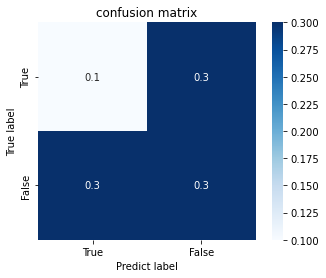

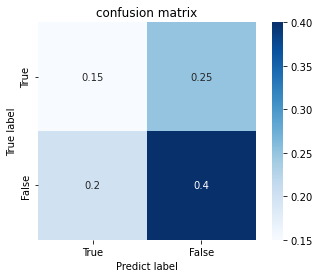

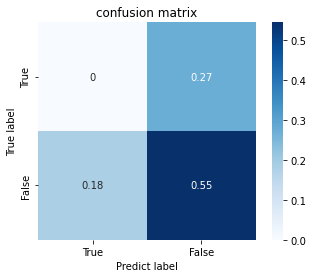

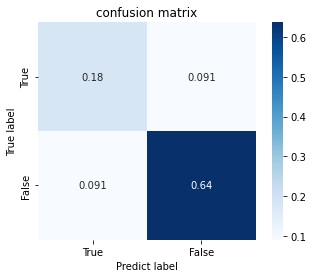

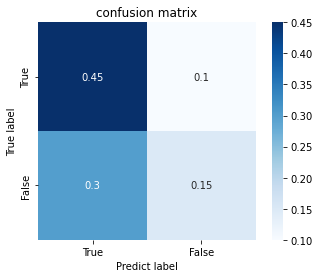

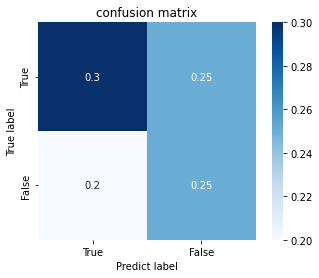

In [40]:
def bcm_train_scores(
    file_path: str = ".",
    file_name: str = "sample",
    clf: callable = RandomForestClassifier(
        min_samples_split=20,
        min_samples_leaf=15,
        random_state=SEED,
        class_weight="balanced",
    ),
    sampling: str = None,
):
    try:
        list_train, list_val = read_preprocessed_df(file_path, file_name)
    except:
        return
    X_train, y_train = list_train[0], list_train[1].map(lambda x: int(x))
    X_val, y_val = list_val[0], list_val[1].map(lambda x: int(x))

    # accuracyの表示
    print("accuracy: ", (y_train == 1).sum() / y_train.shape[0])
    # print("使用特徴量：", X_train.columns)
    print("学習サンプルサイズ：", X_train.shape)
    if sampling == "sm":
        sm = SMOTE(random_state=SEED)
        X_train, y_train = sm.fit_resample(X_train, y_train)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    show_scores(y_val, y_pred)
    plot_confusion_matrix(y_val, y_pred)


# サブグループ削除（一時的に）
subgroup_columns = [
    "CLAUDIN_SUBTYPE",
    #    "NPI_CAT",
    #    "TUMOR_CAT",
    #    "LYMPH_CAT",
]

methods = [
    "variance_threshold",
    #       "mrmr"
]


for method in methods:  # 特徴選択手法の適用
    print("=====" * 10)
    print("method: ", method)
    """
    file_path = "./{0}/{1}/{2}".format(
        config.INTERIM_PREPROCESSED_RECURRENCE_CROSS_DIR,
        "ALL_DATA",
        method,
    )
    bcm_train_scores(
        file_path=file_path, file_name=subgroup, clf=LGBMClassifier(**params)
    )"""
    for subgroup_column in subgroup_columns:  # 各サブグループへの適用
        print("-----" * 10)
        print("subgroup column: ", subgroup_column)
        for subgroup in df_recurrenced[subgroup_column].unique():  # サブグループ毎への適用
            print("....." * 10)
            print("subgroup: ", subgroup)
            file_path = "./{0}/{1}/{2}".format(
                config.INTERIM_PREPROCESSED_RECURRENCE_CROSS_DIR,
                subgroup_column,
                method,
            )
            print("**RandomForest**")
            params = {
                "min_samples_split": 20,
                "min_samples_leaf": 15,
                "random_state": SEED,
                "class_weight": "balanced",
            }
            bcm_train_scores(
                file_path=file_path,
                file_name=subgroup,
                clf=RandomForestClassifier(**params),
            )

            print("**LightGBM**")
            params = {
                "max_bin": 100,
                "num_leaves": 30,
                "n_estimators": 800,
                "class_weight": "balanced",
                "random_state": SEED,
            }
            bcm_train_scores(
                file_path=file_path, file_name=subgroup, clf=LGBMClassifier(**params)
            )

## xgboost

In [5]:
import xgboost as xgb

X_train = X_dict[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["mrmr"]["train"]["X15"]
y_train = y_dict[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["mrmr"]["train"]["y15"]
X_val = X_dict[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["mrmr"]["val"]["X15"]
y_val = y_dict[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["mrmr"]["val"]["y15"]

xgb_train = xgb.DMatrix(X_train, label=y_train, feature_names=X_train.columns)
xgb_val = xgb.DMatrix(X_val, label=y_val, feature_names=X_val.columns)


param = {
    # 二値分類問題
    "objective": "binary:logistic",
}
clf = xgb.train(param, xgb_train)
y_pred_proba = clf.predict(xgb_val)
y_pred = np.where(y_pred_proba > 0.5, 1, 0)

accuracy_score(y_val, y_pred), f1_score(y_val, y_pred)

[05:23:04] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(0.6494845360824743, 0.6730769230769231)